In [3]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, inspect
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
file_path = Path(r'C:\Users\tnguy\personal_projects\SQL\The-Applied-SQL-Data-Analytics-Workshop\Datasets')
file = list(file_path.glob('*by_zip_code.csv'))[0]
file

WindowsPath('C:/Users/tnguy/personal_projects/SQL/The-Applied-SQL-Data-Analytics-Workshop/Datasets/public_transportation_statistics_by_zip_code.csv')

## Create Connection to Postgres

In [5]:
# %load loadcreds.py
import json
with open('keys.json') as f:
    data = json.load(f)

username=data['username']
pswd=data['pswd']
host=data['host']
port=5432
database=data['database']
cnxn_string=f"""postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}"""
engine = create_engine(cnxn_string)


In [4]:
data = pd.read_csv(file)
data.head()

,zip_code,public_transportation_pct,public_transportation_population
0,1379,3.3,13
1,1440,0.4,34
2,1505,0.9,23
3,1524,0.5,20
4,1529,1.8,32


In [9]:
data.shape

(33120, 3)

In [5]:
# Insert Public Transporation Data into Postgresql
data.to_sql('public_transportation', engine, index=False, if_exists='replace')

## Exploratory Data Analysis

### Maximum and Minimum public_transportation_pct

In [6]:
min_max = pd.read_sql_query('''SELECT MIN(public_transportation_pct) As min,
                                    MAX(public_transportation_pct) As max
                                    FROM public_transportation
                                    WHERE public_transportation_pct >= 0''', engine)
min_max

,min,max
0,0.0,100.0


In [26]:
# pandas equivalent
data1 = data.loc[data.public_transportation_pct >= 0]
min_max= {'min':[data1.public_transportation_pct.min()],'max':[data1.public_transportation_pct.max()]}
pd.DataFrame(min_max)

,min,max
0,0.0,100.0


### Average Sales Amount for customers that live in high public transportation usage regions (> 10%) and low ones (<= 10%)

We'll need to get information from customers, sales amount for those customers and their corresponding public transportation regions

In [8]:
# Tables listing
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    print(table_name)

closest_dealerships
countries
customer_sales
customer_survey
public_transportation_by_zip
customers
dealerships
emails
products
sales
salespeople
public_transportation
top_cities_data


In [9]:
# Get sales info
sales = pd.read_sql_query('''SELECT * FROM sales;''',engine)
sales.head()

,customer_id,product_id,sales_transaction_date,sales_amount,channel,dealership_id
0,1,7,2017-07-19 08:38:41,479.992,internet,NaN
1,22,7,2017-08-14 09:59:02,599.990,dealership,20.0
2,145,7,2019-01-20 10:40:11,479.992,internet,NaN
3,289,7,2017-05-09 14:20:04,539.991,dealership,7.0
4,331,7,2019-05-21 20:03:21,539.991,dealership,4.0


The sales table contains information about sales_amount, which is what we're interested in knowing. However, it doesn't tell us where the customers are.

In [43]:
# Get customer info
customers = pd.read_sql_query('''SELECT * FROM customers
                            WHERE postal_code IS NOT NULL;''',engine)
customers.head()
# customers['postal_code'][0]

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added
0,2,Dr,Ode,Stovin,None,ostovin1@npr.org,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,Saint Louis,MO,63116,38.5814,-90.2625,2014-10-02
1,3,None,Braden,Jordan,None,bjordan2@geocities.com,M,192.86.248.59,None,5651 Kennedy Park,Pensacola,FL,32590,30.6143,-87.2758,2018-10-27
2,4,None,Jessika,Nussen,None,jnussen3@salon.com,F,159.165.138.166,615-824-2506,224 Village Circle,Nashville,TN,37215,36.0986,-86.8219,2017-09-03
3,5,None,Lonnie,Rembaud,None,lrembaud4@discovery.com,F,18.131.58.65,786-499-3431,38 Lindbergh Way,Miami,FL,33124,25.5584,-80.4582,2014-03-06
4,6,None,Cortie,Locksley,None,clocksley5@weather.com,M,140.194.59.82,None,6537 Delladonna Drive,Miami,FL,33158,25.6364,-80.3187,2013-03-31


In [99]:
public_transportation = pd.read_sql_query('''SELECT * FROM public_transportation_by_zip 
                                                WHERE public_transportation_pct > 0
                                                ;''', engine)
public_transportation.zip_code = public_transportation.zip_code.astype('int64')
public_transportation.dtypes

level_0                               int64
index                                 int64
zip_code                              int64
public_transportation_pct           float64
public_transportation_population      int64
dtype: object

In [97]:
customers_sales = pd.read_sql_query('''
With customer_sales as 
(SELECT c.customer_id, c.postal_code, s.sales_amount
    FROM customers c
    LEFT JOIN sales s ON c.customer_id = s.customer_id
    WHERE c.city IS NOT NULL),
density as (
SELECT c.customer_id, c.postal_code, c.sales_amount, p.public_transportation_pct,
CASE WHEN p.public_transportation_pct BETWEEN 0.0 AND 10.0 THEN 'low_density'
WHEN p.public_transportation_pct > 0.1 THEN 'high_density'
ELSE 'other' END AS trans_usage
FROM customer_sales c 
JOIN public_transportation_by_zip p ON c.postal_code = p.zip_code
WHERE p.public_transportation_pct BETWEEN 0.0 AND 10.0
OR p.public_transportation_pct > 10.0)
SELECT trans_usage, AVG(sales_amount) avg_sales
FROM density
GROUP BY trans_usage
;''', engine)
customers_sales.head()

,trans_usage,avg_sales
0,high_density,6469.302677
1,low_density,7170.244985


In [98]:
# Pandas Equivalent
customer_sales = pd.merge(customers, sales, how='left', on='customer_id')
columns = ['customer_id', 'postal_code', 'sales_amount']
customer_sales = customer_sales[columns]
customer_sales.postal_code = customer_sales.postal_code.astype('int64')
# customer_sales['postal_code'].fillna(0, inplace=True)
customerSales_transUsage = pd.merge(customer_sales, public_transportation, 
                                    how='inner', left_on='postal_code',right_on='zip_code')
columns = ['customer_id', 'postal_code', 'sales_amount','public_transportation_pct']
filtered_customer_sales = customerSales_transUsage[columns]
filtered_customer_sales.dropna(inplace=True)
conditions = [
    (filtered_customer_sales['public_transportation_pct'] >= 0) 
    & (filtered_customer_sales['public_transportation_pct'] <= 10),
    (filtered_customer_sales['public_transportation_pct'] > 10),
    (filtered_customer_sales['public_transportation_pct'] < 0) 
]
choices = ['low density','high density','other']
filtered_customer_sales['public_transUsage'] = np.select(conditions, choices, default='other')
filtered_customer_sales.groupby('public_transUsage')['sales_amount'].mean()

public_transUsage
high density    6469.302677
low density     7170.244985
Name: sales_amount, dtype: float64

The average sales amount shows that regions with low public transportation usage have higher sales amount.

### Distribution of Public Transportation Usage

Text(0,0.5,'Frequency')

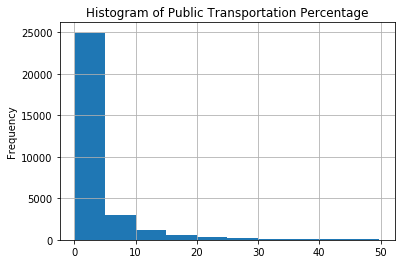

In [101]:
public_transportation.public_transportation_pct.hist()
plt.title('Histogram of Public Transportation Percentage')
plt.ylabel('Frequency')

Most customers live in area with low public transportation usage. 

In [102]:
public_transportation.head()

,level_0,index,zip_code,public_transportation_pct,public_transportation_population
0,0,0,1379,3.3,13
1,1,1,1440,0.4,34
2,2,2,1505,0.9,23
3,3,3,1524,0.5,20
4,4,4,1529,1.8,32


In [105]:
sales.head()

,customer_id,product_id,sales_transaction_date,sales_amount,channel,dealership_id
0,1,7,2017-07-19 08:38:41,479.992,internet,NaN
1,22,7,2017-08-14 09:59:02,599.990,dealership,20.0
2,145,7,2019-01-20 10:40:11,479.992,internet,NaN
3,289,7,2017-05-09 14:20:04,539.991,dealership,7.0
4,331,7,2019-05-21 20:03:21,539.991,dealership,4.0


In [109]:
pd.read_sql_query('''SELECT * FROM sales;''', engine).head()

,customer_id,product_id,sales_transaction_date,sales_amount,channel,dealership_id
0,1,7,2017-07-19 08:38:41,479.992,internet,NaN
1,22,7,2017-08-14 09:59:02,599.990,dealership,20.0
2,145,7,2019-01-20 10:40:11,479.992,internet,NaN
3,289,7,2017-05-09 14:20:04,539.991,dealership,7.0
4,331,7,2019-05-21 20:03:21,539.991,dealership,4.0


In [107]:
# Tables listing
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    print(table_name)

closest_dealerships
countries
customer_sales
customer_survey
public_transportation_by_zip
customers
dealerships
emails
products
sales
salespeople
public_transportation
top_cities_data


In [112]:
sales_count = pd.read_sql_query(''' SELECT
   10 * ROUND(public_transportation_pct/10) AS public_transport,
   COUNT(s.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id) AS sales_per_customer
  FROM customers c
  INNER JOIN public_transportation_by_zip t ON t.zip_code = c.postal_code
  LEFT JOIN sales s ON s.customer_id = c.customer_id
  WHERE public_transportation_pct >= 0
  GROUP BY 1
;''', engine)
sales_count

,public_transport,sales_per_customer
0,0.0,5.725681
1,10.0,5.865889
2,20.0,6.490179
3,30.0,7.050302
4,40.0,6.043796
5,50.0,9.650794


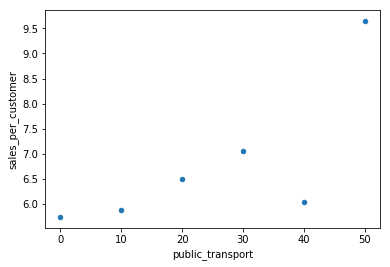

In [115]:
sales_count.plot.scatter(x='public_transport', y='sales_per_customer')

The scatter plot shows that there's a trend in increasing sale where there's increase in public_transportation usage. If the company wants to expand their operations, I would recommend they expand in areas with high public transport usage 